In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import re
import pandas as pd
from transformers import AutoTokenizer
from datasets import Dataset, load_from_disk

### Load Model and Tokenizer

In [3]:

MODEL_CKPT = 'paust/pko-t5-larget'
MODEL_CKPT = 'paust/pko-t5-base'
MODEL_CKPT = 'paust/pko-t5-base'
MODEL_CKPT = 'EleutherAI/polyglot-ko-3.8b'
MODEL_CKPT = 'EleutherAI/polyglot-ko-5.8b'
MODEL_CKPT = 'EleutherAI/polyglot-ko-1.3b'

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

print(MODEL_CKPT)

EleutherAI/polyglot-ko-1.3b


### Load Data

In [4]:
DATA_PATH = 'data/model_dev_raw/model_dev_raw_v4.pickle'

In [5]:
df_data = pd.read_pickle(DATA_PATH)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100146 entries, 0 to 100885
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             100146 non-null  int64         
 1   create_date    100146 non-null  datetime64[ns]
 2   title          100146 non-null  object        
 3   title_content  100146 non-null  object        
 4   len_tokenized  100146 non-null  int64         
 5   label          100146 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 5.3+ MB


In [6]:
# for idx, row in df_data.iterrows():
#     if idx == 1000:
#         break
#     print(f'Row {idx}')
#     print('input')
#     print(row.title_content)
#     print()
#     print('output')
#     print(row.label)
#     print()
#     print()

### 전처리 계획

- 라벨 앞뒤로 붙은 punctuation 제거
- 라벨 내 key-phrases 중에서 띄어쓰기 기준으로 길이 4 이상인 항목 제거 (보류)

### Preprocess

In [7]:
def regulate_sequence(string):
    pattern = re.compile(r'- .+\n') # - 댄스가수 유랑단 > 댄스가스 유랑단; 
    found = pattern.findall(string)
    if len(found) > 5:
        removed = [re.sub(r'^- ', '', keyphrase) for keyphrase in found]
        string = '; '.join(removed)

    pattern = re.compile(r'\d+\. .+\n') # 1. 댄스가수 유랑단 > 댄스가스 유랑단; 
    found = pattern.findall(string)
    if len(found) > 5:
        removed = [re.sub(r'^\d+\. ', '', keyphrase) for keyphrase in found]
        string = '; '.join(removed)
    
    return string

In [8]:
def remove_noises(string):
    string = re.sub(r'key-phrases:', '', string, flags=re.IGNORECASE)
    string = string.replace('\n', ' ').strip()
    
    if string[0] in ';.':
        string = string[1:]
    if string[-1] in ';.':
        string = string[:-1]
    return string.strip()

test_case = '; 농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융; '
test_case = ';농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융. '

remove_noises(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [9]:
def remove_quotes(string):
    quotes = '"' + "'"
    key_phrases = [key_phrase.strip() for key_phrase in string.split(';') if key_phrase != '']

    temp = []
    for key_phrase in key_phrases:
        if len(key_phrase) > 0 and key_phrase[0] in quotes and key_phrase[-1] in quotes:
            key_phrase = key_phrase[1:-1]
        temp.append(key_phrase)
    
    return '; '.join(temp)

test_case = "'농협은행'; 'ESG경영'; '상생경영'; '제1회 대한민국 리딩금융 ESG 어워드'; '친환경경영'; '지배구조'; '녹색금융'"

remove_quotes(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [10]:
def preprocess_str(string):
    string = regulate_sequence(string)
    string = remove_noises(string)
    string = remove_quotes(string)
    return string

In [11]:
def preprocess(df):
    df.rename(columns={'title_content': 'input_text', 'label': 'target_text'}, inplace=True)
    df['target_text'] = df['target_text'].apply(preprocess_str)
    return df

In [12]:
preprocessed_data = preprocess(df_data)

### Check Preprocessed

In [13]:
checker = preprocessed_data.target_text.str.contains('\n')
checker = preprocessed_data.target_text.str.contains(r'^- ', regex=True)
checker = preprocessed_data.target_text.str.contains(r'^\d+\. ', regex=True)
checker = preprocessed_data.target_text.str.contains('key-phrases:')
checked = preprocessed_data[checker]

for idx, row in checked.iterrows():
    print(f'Row {idx}')
    print('target_text')
    print(row.target_text)
    print()

### Add len_tokenized_target_text Col. and Investigate

In [14]:
preprocessed_data['len_tokenized_target_text'] = preprocessed_data.target_text.apply(lambda x: len(tokenizer(x)['input_ids']))

(<Axes: >,
 count    100146.000000
 mean         38.599874
 std          14.909569
 min           1.000000
 25%          30.000000
 50%          35.000000
 75%          42.000000
 max         599.000000
 Name: len_tokenized_target_text, dtype: float64)

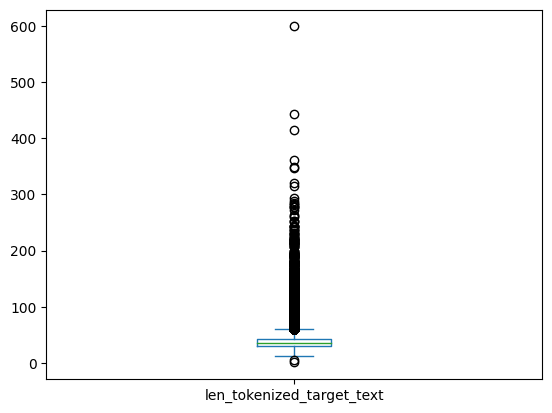

In [15]:
preprocessed_data.len_tokenized_target_text.plot(kind='box'), preprocessed_data.len_tokenized_target_text.describe()

### seq len =< 64 labels only

In [16]:
checker = preprocessed_data.len_tokenized_target_text <= 64
preprocessed_data[checker].len_tokenized_target_text.describe()
preprocessed_data = preprocessed_data[checker]
preprocessed_data.len_tokenized_target_text.describe()

count    96101.000000
mean        36.480963
std          8.544233
min          1.000000
25%         30.000000
50%         35.000000
75%         41.000000
max         64.000000
Name: len_tokenized_target_text, dtype: float64

In [17]:
# cursor = 0
# for idx, row in preprocessed_data.iterrows():
#     keyphrases = row.target_text.split('; ')
#     for keyphrase in keyphrases:
#         if keyphrase not in row.input_text:
#             print(row.input_text)
#             print(keyphrase)
#             print()
#             cursor += 1
#             if cursor == 100:
#                 break
#     if cursor == 100:
#         break

In [18]:
# for idx, row in preprocessed_data.iterrows():
#     print(f'Row {idx}')
#     print('target_text')
#     print(row.target_text)
#     print()

### Save Preprocessed Data

In [19]:
# preprocessed_data.to_pickle('data/model_dev/model_dev_v4.pickle')

### Encoding / Train Eval Split

In [20]:
### seq2seq

prefix = "[generate keyphrases]"

max_input_length = 1024
max_target_length = 64

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["input_text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding=False)

    labels = tokenizer(examples["target_text"], max_length=max_target_length, truncation=True, padding=False)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [21]:
### clm
max_length = 2048


src_prefix = "[generate keyphrases]"
trg_prefix = "[keyphrases generated]"

def preprocess_function(examples):
    inputs = [src_prefix + src + trg_prefix + trg for src, trg in zip(examples["input_text"], examples["target_text"])]
    model_inputs = tokenizer(inputs, max_length=max_length, truncation=True, padding=False)
    return model_inputs

new_tokens = ['[generate keyphrases]', '[keyphrases generated]']
tokenizer.add_tokens(new_tokens)
tokenizer.save_pretrained('clm_tokenizer')

('clm_tokenizer/tokenizer_config.json',
 'clm_tokenizer/special_tokens_map.json',
 'clm_tokenizer/tokenizer.json')

In [28]:
tokenizer.encode(new_tokens)

[30003, 30004]

In [22]:
dataset = Dataset.from_pandas(preprocessed_data).shuffle(seed=100).train_test_split(3000, seed=100)
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [23]:
train_dataset = train_dataset.map(
    preprocess_function, 
    batched=True, 
    num_proc=1, 
    remove_columns=train_dataset.column_names
)

eval_dataset = eval_dataset.map(
    preprocess_function, 
    batched=True, 
    num_proc=1,
)

print(train_dataset)
print(eval_dataset)

Map:   0%|          | 0/93101 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 93101
})
Dataset({
    features: ['id', 'create_date', 'title', 'input_text', 'len_tokenized', 'target_text', 'len_tokenized_target_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})


In [24]:
train_dataset.save_to_disk('data/model_dev/model_dev_v4_polyglot_1.3b_train.hf')
eval_dataset.save_to_disk('data/model_dev/model_dev_v4_polyglot_1.3b_eval.hf')

Saving the dataset (0/1 shards):   0%|          | 0/93101 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

In [25]:
train_dataset = load_from_disk('data/model_dev/model_dev_v4_polyglot_1.3b_train.hf')
eval_dataset = load_from_disk('data/model_dev/model_dev_v4_polyglot_1.3b_eval.hf')

In [26]:
print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 93101
})
Dataset({
    features: ['id', 'create_date', 'title', 'input_text', 'len_tokenized', 'target_text', 'len_tokenized_target_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})


In [32]:
import random

rand_idx = random.randint(0, len(eval_dataset)-1)

sample = eval_dataset['input_ids'][rand_idx]

tokenizer.decode(sample)

'[generate keyphrases]‘나는 솔로’ 상철 “영수 때문에 옥순-영자에 마음 식어”…순자 분량 실종 왜? ‘나는 솔로’ 13기 상철이 데이트 상대로 현숙을 선택했다. iMBC 연예뉴스 사진 iMBC 연예뉴스 사진 22일(수) 방송된 ENA와 SBS플러스가 공동 제작하는 ‘나는 SOLO’ 89회에서 13기 영수와 현숙이 아침을 함께 먹는 모습이 공개됐다. 이날 상철은 데이트 상대로 그의 선택을 바란 영자, 옥순이 아닌 현숙을 선택했다. 상철은 영수가 옥순을 선택할 줄 예상했다며 “남들이 봤을 땐 당연히 현숙 옆으로 갔겠지만, 아니었다. 그리고 현숙은 또 쓸쓸하게 혼자 앉아있구나. ‘불쌍하다, 내가 가면 놀라겠지’ 하고 있었다”라고 밝혔다. 또한, 상철은 전날 밤 옥순과 영자에게 실망해 마음이 식었다고 말했다. 그는 “둘 다 영수님 때문에”라고 밝혔다. 옥순과 영자가 각각 영수와 술 마시며 대화 나눴던 것. 영수는 예상치 못한 상철의 등장에 혼란스러워했다. iMBC 연예뉴스 사진 iMBC 연예뉴스 사진 결국, 선택받지 못한 영자는 ‘고독 정식’이 확정됐다. 영자는 전날 영수와 상철이 자신과 대화한 게 제일 좋았다고 했다며 “너무 곧이곧대로 믿나? 내가 어떤 게 문제인 건지 가늠이 안 돼 답답해”라며 눈물 흘렸다. 시청자들은 각종 SNS와 포털 사이트를 통해 “상철 정말 칼 같다”, “제일 응원하는 순자-광수 커플은 왜 안 보여주는 거지?”, “순자를 왜 통편집하는 건지 진짜 궁금하다”, “광수-순자 분량 무슨 일ㅜㅜ” 등의 반응을 보이고 있다. iMBC 연예뉴스 사진 iMBC 연예뉴스 사진 한편, ‘나는 SOLO’는 결혼을 간절히 원하는 솔로 남녀들이 모여 사랑을 찾기 위해 고군분투하는 극사실주의 데이팅 프로그램이다. 매주 수요일 오후 10시 30분에 방송된다. iMBC 김혜영 | SBS플러스·ENA 화면캡처[keyphrases generated]상철; 영수; 현숙; 옥순; 영자; 데이트; 선택; 대화; 제일 응원하는 순자-광수 커플; 고독 정식'